This notebook will generate a few plots useful to demonstrating the agreement between the SIR ODE's and the nSIR model in some limited cases where the ODE's hold. Most of this code is simply from other files.

In [94]:
# ODE

import SIR_model as sir
import network_manipulation as nm
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import random
import time
import network_stats as ns

dataset_paths = [
'Sociopatterns datasets/conference_2009.dat_',
'Sociopatterns datasets/highschool_2011.csv',
'Sociopatterns datasets/highschool_2012.csv',
'Sociopatterns datasets/highschool_2013.csv',
'Sociopatterns datasets/hospital_2010.dat_',
'Sociopatterns datasets/primaryschool_2014.csv',
'Sociopatterns datasets/workplace_2013.dat',
'Sociopatterns datasets/workplace_2015.dat_']

dataset_names = [
    'Conference 1', 
    'Highschool 1', 
    'Highschool 2', 
    'Highschool 3', 
    'Hospital 1', 
    'Primaryschool 1', 
    'Workplace 1', 
    'Workplace 2']

simulation_params = {}
simulation_params['Time'] = 50
simulation_params['Runs'] = 25
simulation_params['Initial'] = 0.05
simulation_params['Beta'] = 0.8
simulation_params['Gamma'] = 0.2
simulation_params['Threshold'] = 65*2 # only affects simulation

G = nm.build_nxgraph(dataset_paths[3], False) # un-normalised weighted networkx graph

N = len(G) 

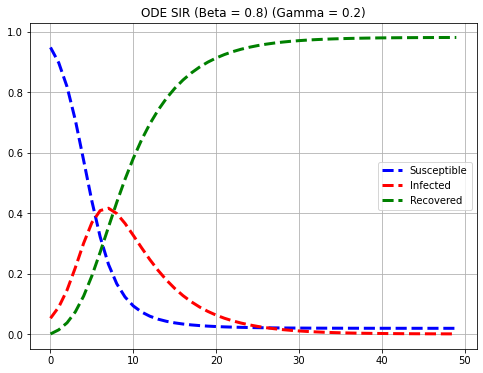

In [2]:
# ODE
plt.figure(figsize=(8, 6))
plt.grid()

analytic_time = np.arange(0, simulation_params['Time'])
S, I, R = sir.analytic_sol(G, simulation_params)

plt.plot(analytic_time, S, linewidth = 3, label = 'Susceptible', color = 'b', linestyle = 'dashed', alpha = 1)
plt.plot(analytic_time, I, linewidth = 3, label = 'Infected', color = 'r', linestyle = 'dashed', alpha = 1)
plt.plot(analytic_time, R, linewidth = 3, label = 'Recovered', color = 'g', linestyle = 'dashed', alpha = 1)

plt.title('ODE SIR (Beta = ' + str(simulation_params['Beta']) + ') (Gamma = ' + str(simulation_params['Gamma']) + ')')
plt.legend(loc = 'center right')

plt.show()

In [107]:
def test_sir(H, params): # propogation algorithm for basic SIR on network
    update_dict = {}
    nodes = list(H.nodes)
    for node in nodes:
        if H.nodes[node]['status'] == 0:
            connections = list(H.neighbors(node))
            connection = random.choice(connections)
            if H.nodes[connection]['status'] == 1:
                stat = H[node][connection]['weight'] * params['Beta']
                #if stat < 0.01:
                    #print(stat)
                if np.random.random() < stat:
                    update_dict[connection] = 0
                    
    for node in list(H.nodes):
        if H.nodes[node]['status'] == 0:
            if np.random.random() < params['Gamma']:
                H.nodes[node]['status'] = -1
    
    for node in list(update_dict.keys()):
        H.nodes[node]['status'] = 0  
    
    return H
    
def simulate_sir(H, params):
    H = sir.initialise_potential(H, params)
    H = sir.initialise_status(H)
    S = []
    I = []
    R = []
    s, i, r = sir.check_states(H)
    S.append(s)
    I.append(i)
    R.append(r)
    for i in range(params['Time']):
        H = test_sir(H, params)
        s, i, r = sir.check_states(H)
        S.append(s)
        I.append(i)
        R.append(r)
    return S, I, R

def smooth_basic(H, params):
    s_smooth = []
    i_smooth = []
    r_smooth = []
    s_runs = []
    i_runs = []
    r_runs = []
    
    M = params['Runs']
    T = params['Time']
    
    for i in range(M):
        #print(i)
        #print(str(round((i+1)*100/M, 1)) + '%') # display progress of smoothing
        s_run, i_run, r_run = simulate_sir(H, params)
        s_runs.append(s_run)
        i_runs.append(i_run)
        r_runs.append(r_run)
    
    for i in range(T): # smoothing susceptible time series
        total = 0
        for j in range(M):
            total += s_runs[j][i]     
        total = total / M   
        s_smooth.append(total)
        
    for i in range(T): # smoothing infected time series
        total = 0
        for j in range(M):
            total += i_runs[j][i]     
        total = total / M   
        i_smooth.append(total)

    for i in range(T): # smoothing recovered time series
        total = 0
        for j in range(M):
            total += r_runs[j][i]     
        total = total / M   
        r_smooth.append(total)
        
    return s_smooth, i_smooth, r_smooth

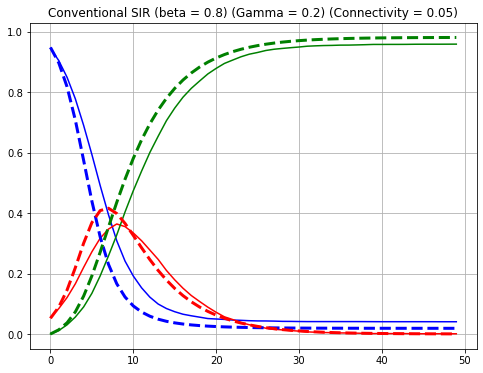

In [136]:
# ODE vs complete network (unweighted graph)

connectivity = 0.05

H = nx.fast_gnp_random_graph(N, connectivity) # Complete graph
H = sir.initialise_weight(H, 1) # give every edge a weight of 1

s, i, r = smooth_basic(H, simulation_params)
S, I, R = sir.analytic_sol(H, simulation_params)
t = np.arange(0, simulation_params['Time'])

plt.figure(figsize = (8,6))
plt.title('Conventional SIR (beta = ' + str(simulation_params['Beta']) + ') (Gamma = ' + str(simulation_params['Gamma']) + ') (Connectivity = ' + str(connectivity) + ')')

# numerical
plt.plot(t, s, label = 'susceptible', color = 'b')
plt.plot(t, i, label = 'infected', color = 'r')
plt.plot(t, r, label = 'recovered', color = 'g')

# analytic
plt.plot(t, S, linewidth = 3, color = 'b', linestyle = 'dashed', alpha = 1)
plt.plot(t, I, linewidth = 3, color = 'r', linestyle = 'dashed', alpha = 1)
plt.plot(t, R, linewidth = 3,  color = 'g', linestyle = 'dashed', alpha = 1)

plt.grid()


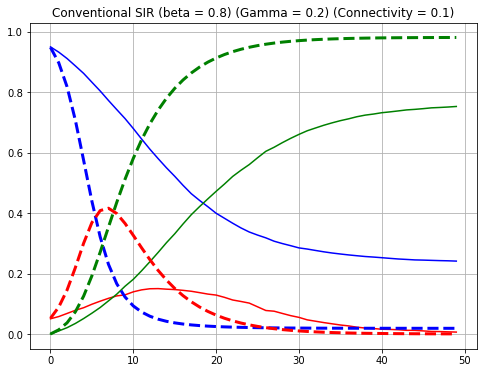

In [137]:
# ODE vs complete network (randomly weighted graph)

def initialise_weight_random(G): # Sets weight to all edges to 'weight'
    nodes = list(G.nodes)
    for node in nodes:
        connections = list(G.neighbors(node))
        for connection in connections:
            G[node][connection]['weight'] = random.random()
    return G

connectivity = 0.1
H = nx.fast_gnp_random_graph(N, connectivity) # Complete graph
H = initialise_weight_random(H)

s, i, r = smooth_basic(H, simulation_params)
S, I, R = sir.analytic_sol(H, simulation_params)
t = np.arange(0, simulation_params['Time'])

plt.figure(figsize = (8,6))
plt.title('Conventional SIR (beta = ' + str(simulation_params['Beta']) + ') (Gamma = ' + str(simulation_params['Gamma']) + ') (Connectivity = ' + str(connectivity) + ')')

# numerical
plt.plot(t, s, label = 'susceptible', color = 'b')
plt.plot(t, i, label = 'infected', color = 'r')
plt.plot(t, r, label = 'recovered', color = 'g')

# analytic
plt.plot(t, S, linewidth = 3, color = 'b', linestyle = 'dashed', alpha = 1)
plt.plot(t, I, linewidth = 3, color = 'r', linestyle = 'dashed', alpha = 1)
plt.plot(t, R, linewidth = 3,  color = 'g', linestyle = 'dashed', alpha = 1)

plt.grid()

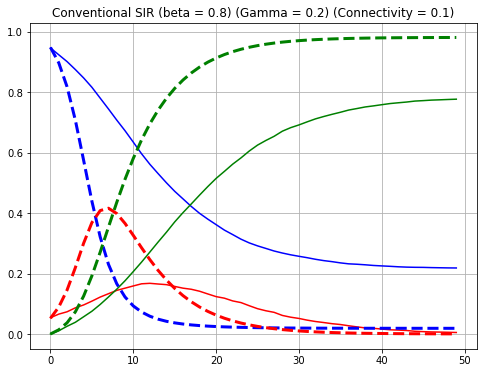

In [145]:
# ODE vs complete network (linear weighted graph)

def initialise_weight_linear(G): # Sets weight to all edges to 'weight'
    nodes = list(G.nodes)
    for node in nodes:
        connections = list(G.neighbors(node))
        for connection in connections:
            G[node][connection]['weight'] = ns.linear(random.random(), -1, 1)
    return G

connectivity = 0.1
H = nx.fast_gnp_random_graph(N, connectivity) # Complete graph
H = initialise_weight_linear(H)

s, i, r = smooth_basic(H, simulation_params)    
S, I, R = sir.analytic_sol(H, simulation_params)
t = np.arange(0, simulation_params['Time'])

plt.figure(figsize = (8,6))
plt.title('Conventional SIR (beta = ' + str(simulation_params['Beta']) + ') (Gamma = ' + str(simulation_params['Gamma']) + ') (Connectivity = ' + str(connectivity) + ')')

# numerical
plt.plot(t, s, label = 'susceptible', color = 'b')
plt.plot(t, i, label = 'infected', color = 'r')
plt.plot(t, r, label = 'recovered', color = 'g')

# analytic
plt.plot(t, S, linewidth = 3, color = 'b', linestyle = 'dashed', alpha = 1)
plt.plot(t, I, linewidth = 3, color = 'r', linestyle = 'dashed', alpha = 1)
plt.plot(t, R, linewidth = 3,  color = 'g', linestyle = 'dashed', alpha = 1)

plt.grid()

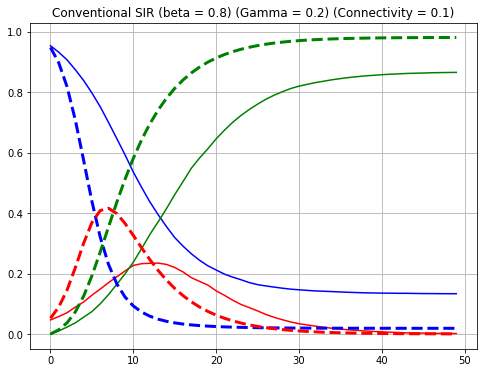

In [144]:
# ODE vs complete network (exponential weighted graph)

def initialise_weight_exponential(G): # Sets weight to all edges to 'weight'
    nodes = list(G.nodes)
    for node in nodes:
        connections = list(G.neighbors(node))
        for connection in connections:
            G[node][connection]['weight'] = ns.exponential(random.random(), -1, 1)
    return G

connectivity = 0.1
H = nx.fast_gnp_random_graph(N, connectivity) # Complete graph
H = initialise_weight_exponential(H)

s, i, r = smooth_basic(H, simulation_params)    
S, I, R = sir.analytic_sol(H, simulation_params)
t = np.arange(0, simulation_params['Time'])

plt.figure(figsize = (8,6))
plt.title('Conventional SIR (beta = ' + str(simulation_params['Beta']) + ') (Gamma = ' + str(simulation_params['Gamma']) + ') (Connectivity = ' + str(connectivity) + ')')

# numerical
plt.plot(t, s, label = 'susceptible', color = 'b')
plt.plot(t, i, label = 'infected', color = 'r')
plt.plot(t, r, label = 'recovered', color = 'g')

# analytic
plt.plot(t, S, linewidth = 3, color = 'b', linestyle = 'dashed', alpha = 1)
plt.plot(t, I, linewidth = 3, color = 'r', linestyle = 'dashed', alpha = 1)
plt.plot(t, R, linewidth = 3,  color = 'g', linestyle = 'dashed', alpha = 1)

plt.grid()

4.0954758331382605e-44

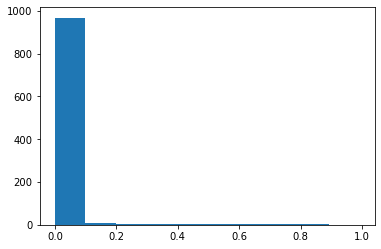

In [100]:
# Checking if the randomly generated weights are behaving as predicted

test = []

for i in range(1000):
    test.append(ns.exponential(random.random(), -100, 1))

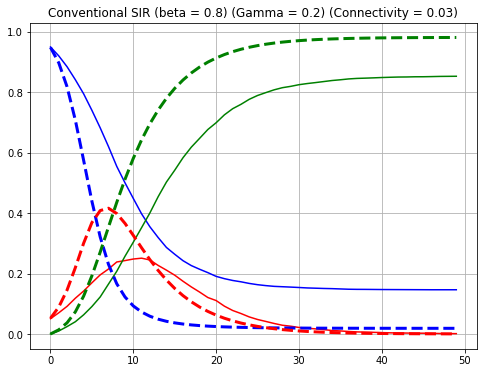

In [148]:
# ODE vs complete network (power weighted graph)

def initialise_weight_power(G): # Sets weight to all edges to 'weight'
    nodes = list(G.nodes)
    for node in nodes:
        connections = list(G.neighbors(node))
        for connection in connections:
            G[node][connection]['weight'] = ns.power(random.random(), 0.3, -1)
    return G

connectivity = 0.03
H = nx.fast_gnp_random_graph(N, connectivity) # Complete graph
H = initialise_weight_power(H)

s, i, r = smooth_basic(H, simulation_params)    
S, I, R = sir.analytic_sol(H, simulation_params)
t = np.arange(0, simulation_params['Time'])

plt.figure(figsize = (8,6))
plt.title('Conventional SIR (beta = ' + str(simulation_params['Beta']) + ') (Gamma = ' + str(simulation_params['Gamma']) + ') (Connectivity = ' + str(connectivity) + ')')

# numerical
plt.plot(t, s, label = 'susceptible', color = 'b')
plt.plot(t, i, label = 'infected', color = 'r')
plt.plot(t, r, label = 'recovered', color = 'g')

# analytic
plt.plot(t, S, linewidth = 3, color = 'b', linestyle = 'dashed', alpha = 1)
plt.plot(t, I, linewidth = 3, color = 'r', linestyle = 'dashed', alpha = 1)
plt.plot(t, R, linewidth = 3,  color = 'g', linestyle = 'dashed', alpha = 1)

plt.grid()

# For higher +ve powers (about 4 or higher), a greater fraction of weights are close to zero which leads to a lack of spread of infection
# For -ve powers, there is increased infection seen as compared to the base case as on interval [0,1] the weight is greater than 1 which increases the chance of infection
# When modulating the coefficient of the power law we then begin to see lower infection as we would expect as the function is not always greater than 1


After trying these weighting schemes it is clear that there is some leeway within which the basic SIR spread on weighted networks will agree with the ODE solutions

I need to define some metric to calculate the similarity between the two sets of curves and use this to give a more rigourous range of weighting parameter values for which there is agreement with the ODE's

However, a conclusion is, generally, for weighted networks the ODE model is not a good fit (this should be clear anyway as what we are doing is effectively changing the beta value of the sysem - in this regard, does it make sense to always change the beta value to be less than the original or should we also acount for potential increases ... rather I think it makes more sense for the original beta value to be thought of as an average for the system and then weights that are added should be sampled from a normal distribution - this will retain characteristics [for certain beta values at least] but is this really what we mean by beta ... after doing a quick chatGPT, \beta is defined as: 'beta = lambda * sum(w_ij * A_ij) / k_i,' so in weighted network models what I think of beta is really lambda which gets scaled by the network structure to give the same overall beta parameter - I believe this is a requirement to keep consistent with the behaviour we expect from a disease. This is the next step forwards for our modelling).

After implementing the modulated beta value we will need implement n-SIR model

Additionally, the effects of decreasing the connectivity of the graph remains about the same despite changing the weights.